# Logistic Regression for Two-Option Juice Choice Task

Many decision tasks require the subjects to choose between two options. Here, we show how to use logistic regression to analyze the choice pattern when subjects choose between two juice options with variable quantities, and the two options are presented as the same time. The example data is from non-human primate (rhesus monkeys) studies. 

Juice Choice Task (Padoa-Schioppa and Assad, 2006)


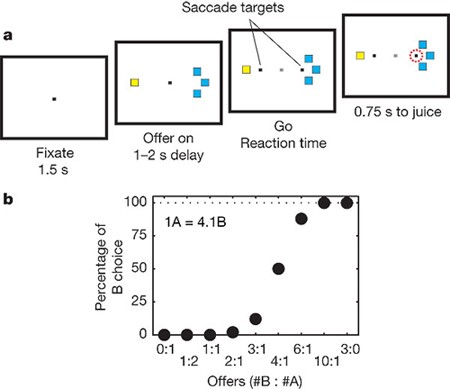

In [1]:
from IPython.display import Image, display
print('Juice Choice Task (Padoa-Schioppa and Assad, 2006)')
!git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
display(Image('LogisticRegression_tutorial/pics/JC_tasks.jpg', width=400, unconfined=True)) # use it only for google colab 
# display(Image('../pics/JC_tasks.jpg', width=400, unconfined=True))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

## Simple regression

### Step 1: load data

First, let's load example data file named as `goodTrials_JC.mat`. It only contains trials that monkey has successfully chosen one of the juice option.  

`goodTrials_JC.mat` is a $N \times 4$, where $N$ is the number of the trials in this session, and in this example, $N =176$. The columns of this matrix indicated:

 - *column 1*: the trial number.

 - *column 2*: the quantity of juice A. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 3*: the quantity of juice B. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 4*: the chosen juice type, with 1 indicating A and 2 indicating B.


In [3]:
# !git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
data = loadmat('LogisticRegression_tutorial/data/goodtrials_JC.mat')['goodTrials_JC'] # use it only for goole colab
# data = loadmat('../data/goodtrials_JC.mat')['goodTrials_JC'] # loadmat is a function in scipy.io used to load Matlab data file

# Independent variables
triNum = np.abs(data[:,0]) # trial number
QA = np.abs(data[:,1]) # quantity of juice A
QB = np.abs(data[:,2]) # quantity of juice B
SideA = np.sign(data[:,1]) # side of target A. -1: left, 1: right, 0 forced choice

# Dependent variables
CJ = data[:,3]-1 # the type of chosen juice. 0: chosen A, 1: chosen B

ind_forced = (data[:,1] == 0) | (data[:,2] == 0) # index of forced choice
ind_nonforced = ~ind_forced

### Step 2: probit regression fitting
we use probit regression to fit the choice pattern. the model is as follows:

$ choice B = \Phi(X) $

$ X = a_0 + a_1 log(q_B/q_A) $

where $choice B = 1$ if juice B is chosen and 0 otherwise. $\Phi$ is the cumulative function of a Gaussian distribution (probit link). $q_A$ and $q_B$ are the juice quantity for A and B in each trial. $a_0$ and $a_1$ are the fitted parameters, from which we define the relative value ($\rho$) between A and B as $\rho = exp(-a_0/a_1)$ and the sigmoid steepness ($\eta$) as $\eta = a_1$. Relative value measures the indifference point at which the value of A and B are the same, that is, $1 q_A = \rho q_B$; steepness reflects the choice accuracy which is inverse to the choice variability.

In [4]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit

In [5]:
# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X = np.log(QB[ind_nonforced]/QA[ind_nonforced]) # log ratio
const = np.ones(X.shape)

# probit regression
model = Probit(Y, np.transpose([const, X]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.285275
         Iterations 8


### Step 3: plotting
We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities). We also exclude the forced choice for convenience.

In [8]:
# We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities)
def OfferTypeTable(alltrials,allchoice):
    # calculate offer types
    table01 = np.unique(alltrials,axis = 1)
    LogRatio = np.log(table01[0,:]/table01[1,:])
    ntritype = np.shape(table01)[1]
    
    # calculate the percentage of choice B #
    PB = np.array([]) # percentage of choice B
    xtickname = np.array([]) # x axis tick names
    for itritype in np.arange(0, ntritype,1):
        ind_itritype = (np.transpose(alltrials) == np.transpose(table01)[itritype,:]).all(axis=1)
        CJ_itritype = allchoice[ind_itritype]
        PB_itritype = np.sum(CJ_itritype)/(np.shape(CJ_itritype)[0])
        PB = np.append(PB,PB_itritype)
        xtickname_itritype = np.array2string(table01[0,itritype])+'/'+np.array2string(table01[1,itritype])
        xtickname = np.append(xtickname,xtickname_itritype)
    
    return (LogRatio, PB, xtickname)

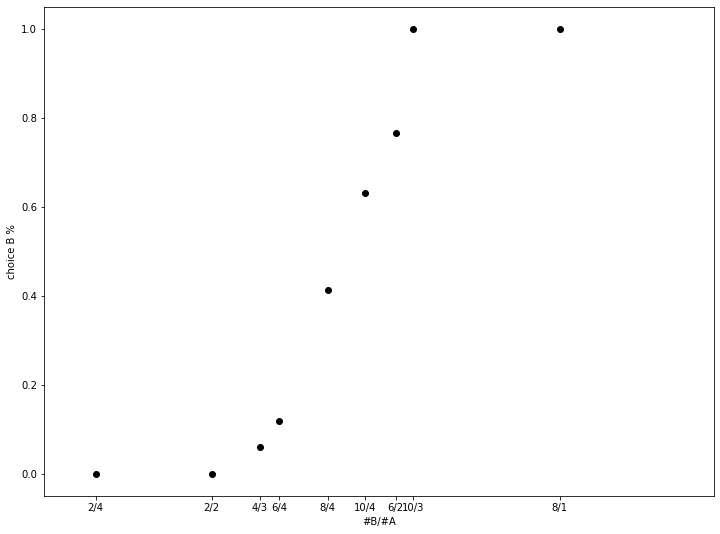

In [9]:
#####
# plot the results #
#####
(LogRatio, PB, xtickname) = OfferTypeTable([QB[ind_nonforced], QA[ind_nonforced]], CJ[ind_nonforced])

# plot data point - offer types
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio,PB, 'ko')
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio)
ax.set_xticklabels(xtickname); 

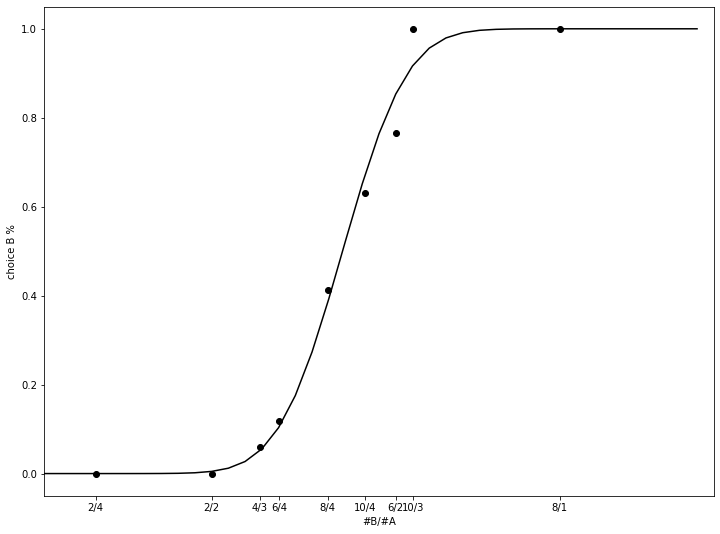

In [10]:
# plot sigmoidal curve     
X_plot = np.arange(np.floor(np.min(LogRatio)), np.ceil(np.max(LogRatio)), 0.1)
const_plot = np.ones(np.size(X_plot))
Y_plot = probit_model.predict(np.transpose([const_plot, X_plot]))

# plot
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio,PB, 'ko')
plt.plot(X_plot,Y_plot,'k')
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio)
ax.set_xticklabels(xtickname); 

In [11]:
rho = np.exp(-betas[0]/betas[1])
print('relative value ρ is: ', np.array2string(rho))
eta = betas[1]
print('steepness η is: ', np.array2string(eta))


relative value ρ is:  2.18647539
steepness η is:  3.30671802


## Regression with biases

### 1. Side bias

Side bias quantifies the bias in favor of one side of the target. The model is as follows:

$ choice B = \Phi(X) $

$ X = a_0 + a_1 log(q_B/q_A) + a_2 (\delta_{A, right} - \delta_{B, right})$

where $\delta_{J, right} = 1$ if the target associated with juice J is presented on the right and 0 otherwise, and $J = A, B$. The side bias was defined as $\xi = a_2$. A measure $\xi > 0$ indicated that, other things equal, the animal tends to choose the left target.

In [12]:
# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X1 = np.log(QB[ind_nonforced]/QA[ind_nonforced])
X2 = SideA[ind_nonforced]
const = np.ones(X1.shape)

# probit regression
model = Probit(Y, np.transpose([const, X1, X2]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.281498
         Iterations 8


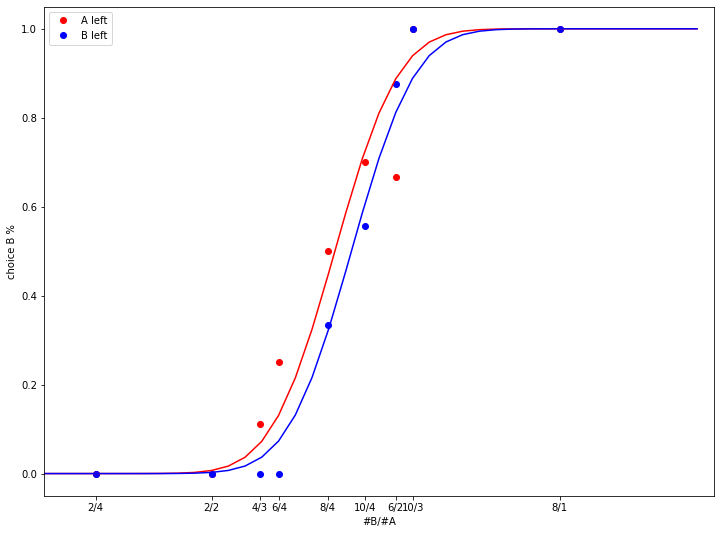

In [13]:
#####
# plot the results #
#####
# calculate offer types

# for A left trials
(LogRatio_AL, PB_AL, xtickname_AL) = OfferTypeTable([QB[ind_nonforced & (SideA == -1)], QA[ind_nonforced & (SideA == -1)]], CJ[ind_nonforced & (SideA == -1)])
# for A right (B left) trials
(LogRatio_AR, PB_AR, xtickname_AR) = OfferTypeTable([QB[ind_nonforced & (SideA ==  1)], QA[ind_nonforced & (SideA ==  1)]], CJ[ind_nonforced & (SideA ==  1)])
    
# plot sigmoidal curve     
X_plot = np.arange(np.floor(np.min(LogRatio_AL)), np.ceil(np.max(LogRatio_AL)), 0.1)
const_plot = np.ones(np.size(X_plot))
AL_plot = -np.ones(np.size(X_plot))
AR_plot = np.ones(np.size(X_plot))
Y_plot_AL = probit_model.predict(np.transpose([const_plot, X_plot, AL_plot]))
Y_plot_AR = probit_model.predict(np.transpose([const_plot, X_plot, AR_plot]))

# plot
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio_AL, PB_AL, 'ro')
plt.plot(LogRatio_AR, PB_AR, 'bo')
plt.plot(X_plot,Y_plot_AL, 'r')
plt.plot(X_plot,Y_plot_AR, 'b')
plt.legend(["A left", "B left"])
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio_AL)
ax.set_xticklabels(xtickname_AL); 

In [14]:
rho_AR = np.exp(-(betas[0]+betas[2])/betas[1])
print('B left trial relative value ρ is: ', np.array2string(rho_AR))
rho_AL = np.exp(-(betas[0]-betas[2])/betas[1])
print('A left trial relative value ρ is: ', np.array2string(rho_AL))
xi = betas[2]
print('Side bias is: ', np.array2string(xi))

B left trial relative value ρ is:  2.30533376
A left trial relative value ρ is:  2.08822077
Side bias is:  -0.16516096


### 2.1. Choice hysteresis: juice type

Subjects tend to choose the same option as in the previous trials, and choice hysteresis quantifies such history bias. The choices can be the same in different dimensions. The first model that we examine quantifies the choice hysteresis based on the same juice type. The model is as follows:

$ choice B = \Phi(X) $

$ X = a_0 + a_1 log(q_B/q_A) + a_2 (\delta_{n-1, B} - \delta_{n-1, A})$

where $\delta_{n-1, J} = 1$ if in the previous trial the animal chose juice J and 0 otherwise, and $J = A, B$. Choice hysteresis is quantified as $\theta_{juice} = a_2$. A measure of $\theta_{juice} > 0$ indicated that, other things equal, the animal tends to choose the same juice chosen in the previous trial.

In [15]:
# define choice hysteresis term
ind_ChA = CJ == 0; # index of trial with chosen A
triNum_ChA = triNum[ind_ChA]; # trial number of chosen A
ind_ChB = CJ == 1; # index of trial with chosen B
triNum_ChB = triNum[ind_ChB]; # trial number of chosen B
#
CJ_n1 = np.zeros(np.size(triNum)); # choice of previous trial (n-1): -1 for A, 1 for B, 0 for else
CJ_n1[np.isin(triNum,triNum_ChA+1)] = -1; 
CJ_n1[np.isin(triNum,triNum_ChB+1)] = 1; 

# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X1 = np.log(QB[ind_nonforced]/QA[ind_nonforced])
X2 = CJ_n1[ind_nonforced]
const = np.ones(X1.shape)

# probit regression
model = Probit(Y, np.transpose([const, X1, X2]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.279045
         Iterations 8


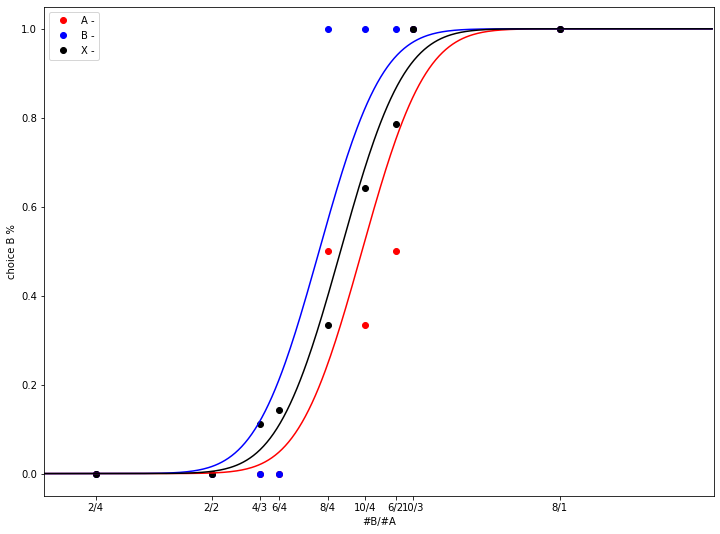

In [16]:
#####
# plot the results #
#####
# calculate offer types

# for trials with previous A choice
(LogRatio_pA, PB_pA, xtickname_pA) = OfferTypeTable([QB[ind_nonforced & (CJ_n1 == -1)], QA[ind_nonforced & (CJ_n1 == -1)]], CJ[ind_nonforced & (CJ_n1 == -1)])
# for trials with previous B choice
(LogRatio_pB, PB_pB, xtickname_pB) = OfferTypeTable([QB[ind_nonforced & (CJ_n1 ==  1)], QA[ind_nonforced & (CJ_n1 ==  1)]], CJ[ind_nonforced & (CJ_n1 ==  1)])
# for trials with previous non choice
(LogRatio_pX, PB_pX, xtickname_pX) = OfferTypeTable([QB[ind_nonforced & (CJ_n1 ==  0)], QA[ind_nonforced & (CJ_n1 ==  0)]], CJ[ind_nonforced & (CJ_n1 ==  0)])
    
# plot sigmoidal curve     
X_plot = np.arange(np.floor(np.min(LogRatio_pA)), np.ceil(np.max(LogRatio_pA)), 0.01)
const_plot = np.ones(np.size(X_plot))
pA_plot = -np.ones(np.size(X_plot))
pB_plot = np.ones(np.size(X_plot))
pX_plot = np.zeros(np.size(X_plot))
Y_plot_pA = probit_model.predict(np.transpose([const_plot, X_plot, pA_plot]))
Y_plot_pB = probit_model.predict(np.transpose([const_plot, X_plot, pB_plot]))
Y_plot_pX = probit_model.predict(np.transpose([const_plot, X_plot, pX_plot]))

# plot
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio_pA, PB_pA, 'ro')
plt.plot(LogRatio_pB, PB_pB, 'bo')
plt.plot(LogRatio_pX, PB_pX, 'ko')
plt.plot(X_plot,Y_plot_pA, 'r')
plt.plot(X_plot,Y_plot_pB, 'b')
plt.plot(X_plot,Y_plot_pX, 'k')
plt.legend(["A -", "B -", "X -"])
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio_pX)
ax.set_xticklabels(xtickname_pX); 

In [17]:
rho_pB = np.exp(-(betas[0]+betas[2])/betas[1])
print('B- trial relative value ρ is: ', np.array2string(rho_pB))
rho_pA = np.exp(-(betas[0]-betas[2])/betas[1])
print('A- trial relative value ρ is: ', np.array2string(rho_pA))
rho_pX = np.exp(-(betas[0])/betas[1])
print('X- trial relative value ρ is: ', np.array2string(rho_pX))
theta = betas[2]
print('Choice hysteresis (juice type) is: ', np.array2string(theta))

B- trial relative value ρ is:  1.90022089
A- trial relative value ρ is:  2.45493769
X- trial relative value ρ is:  2.15984349
Choice hysteresis (juice type) is:  0.42940185


### 2.2. Choice hysteresis: side

The second model that we examine quantifies the choice hysteresis based on the same target position side. The model is as follows:

$ choice B = \Phi(X) $

$ X = a_0 + a_1 log(q_B/q_A) + a_2 (\delta_{n-1, side B} - \delta_{n-1, side A})$

where $\delta_{n-1, side J} = 1$ if in the target associated with juice J was in the same spatial position as that chosen in the previous trial and 0 otherwise, and $J = A, B$. Choice hysteresis is quantified as $\theta_{side} = a_2$. A measure of $\theta_{side} > 0$ indicated that, other things equal, the animal tends to choose the same saccade target position in the previous trial.

In [18]:
# define choice hysteresis (side) term
ind_chosenL = (CJ*2-1)*SideA == 1;
triNum_chosenL  = triNum[ind_chosenL]; # trialnum of choosing left
ind_chosenR = (CJ*2-1)*SideA == -1; 
triNum_chosenR  = triNum[ind_chosenR]; # trialnum of choosing right
trialNum_AR = triNum[SideA== 1]; # trialnum of A on the right side 
trialNum_AL = triNum[SideA==-1]; # trialnum of A on the left side 
trialNum_sameA = np.concatenate((trialNum_AL[np.isin(trialNum_AL,triNum_chosenL+1)],trialNum_AR[np.isin(trialNum_AR,triNum_chosenR+1)]))
trialNum_sameB = np.concatenate((trialNum_AL[np.isin(trialNum_AL,triNum_chosenR+1)],trialNum_AR[np.isin(trialNum_AR,triNum_chosenL+1)]))
PoHyst = np.zeros(np.size(triNum)); # chosen side of previous trial (n-1): -1 for same side of A, 1 for same side of B, 0 for else
PoHyst[np.isin(triNum,trialNum_sameA+1)] = -1; 
PoHyst[np.isin(triNum,trialNum_sameB+1)] = 1; 

# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X1 = np.log(QB[ind_nonforced]/QA[ind_nonforced])
X2 = PoHyst[ind_nonforced]
const = np.ones(X1.shape)

# probit regression
model = Probit(Y, np.transpose([const, X1, X2]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.284940
         Iterations 8


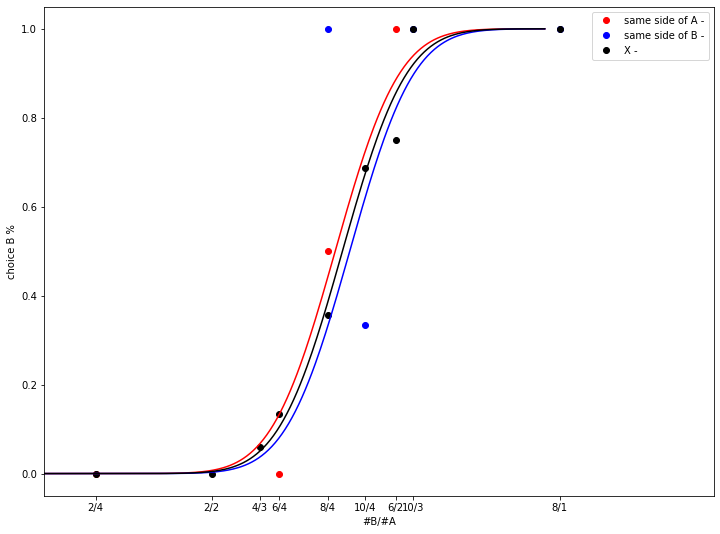

In [19]:
#####
# plot the results #
#####
# calculate offer types

# for trials with the same side of previous A choice
(LogRatio_pA, PB_pA, xtickname_pA) = OfferTypeTable([QB[ind_nonforced & (PoHyst == -1)], QA[ind_nonforced & (PoHyst == -1)]], CJ[ind_nonforced & (PoHyst == -1)])
# for trials with the same side of previous B choice
(LogRatio_pB, PB_pB, xtickname_pB) = OfferTypeTable([QB[ind_nonforced & (PoHyst ==  1)], QA[ind_nonforced & (PoHyst ==  1)]], CJ[ind_nonforced & (PoHyst ==  1)])
# for trials with previous non choice
(LogRatio_pX, PB_pX, xtickname_pX) = OfferTypeTable([QB[ind_nonforced & (PoHyst ==  0)], QA[ind_nonforced & (PoHyst ==  0)]], CJ[ind_nonforced & (PoHyst ==  0)])
   
    
# plot sigmoidal curve     
X_plot = np.arange(np.floor(np.min(LogRatio_pA)), np.ceil(np.max(LogRatio_pA)), 0.01)
const_plot = np.ones(np.size(X_plot))
pA_plot = -np.ones(np.size(X_plot))
pB_plot = np.ones(np.size(X_plot))
pX_plot = np.zeros(np.size(X_plot))
Y_plot_pA = probit_model.predict(np.transpose([const_plot, X_plot, pA_plot]))
Y_plot_pB = probit_model.predict(np.transpose([const_plot, X_plot, pB_plot]))
Y_plot_pX = probit_model.predict(np.transpose([const_plot, X_plot, pX_plot]))

# plot
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio_pA, PB_pA, 'ro')
plt.plot(LogRatio_pB, PB_pB, 'bo')
plt.plot(LogRatio_pX, PB_pX, 'ko')
plt.plot(X_plot,Y_plot_pA, 'r')
plt.plot(X_plot,Y_plot_pB, 'b')
plt.plot(X_plot,Y_plot_pX, 'k')
plt.legend(["same side of A -", "same side of B -", "X -"])
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio_pX)
ax.set_xticklabels(xtickname_pX); 

In [20]:
rho_pB = np.exp(-(betas[0]+betas[2])/betas[1])
print('same side of B- trial relative value ρ is: ', np.array2string(rho_pB))
rho_pA = np.exp(-(betas[0]-betas[2])/betas[1])
print('same side of A- trial relative value ρ is: ', np.array2string(rho_pA))
rho_pX = np.exp(-(betas[0])/betas[1])
print('other trial relative value ρ is: ', np.array2string(rho_pX))
theta = betas[2]
print('Choice hysteresis (juice type) is: ', np.array2string(theta))

same side of B- trial relative value ρ is:  2.28188282
same side of A- trial relative value ρ is:  2.09224062
other trial relative value ρ is:  2.18500525
Choice hysteresis (juice type) is:  -0.14431545
